In [1]:
from simulator import Sim
from base_strategy import BaseStrategy

from stoikov_strategy import StoikovStrategy, FutureStrategy

from get_info import get_pnl
from load_data import load_md_from_file


import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

PATH_TO_FILE = '../md/btcusdt:Binance:LinearPerpetual/'
T = pd.Timedelta(120, 'm').delta

In [34]:
class SimpleMicroPrice:
    def __init__(self, n_imb, m_spread, alpha):
        self.n_imb = n_imb
        self.m_spread = m_spread
        self.alpha = alpha
        
        
        self.imb_set = list(range(0, n))
        
        
    def _round_imbalance(self, imb):
        return (imb * self.n_imb).astype(int)
    
    
    def _round_spread(self, spread):
        spread = np.round_(spread, 4)
        spread = (np.clip(spread, 0, self.max_spread) / self.min_spread).astype(int)
        return spread
    
    def _round_dm(self, dm):
        dm = np.round_(dm, 2)
        dm = np.clip(dm, self.q1, self.q2)
        return dm
    
    
    def _round(self, imb, spread, dm=None):
        imb = self._round_imbalance(imb)
        spread = self._round_spread(spread)
        if dm is None:
            return imb, spread
        dm = self._round_dm(dm)
        return imb, spread, dm
    
    
    def _fit_rounder(self, imb, spread, dm):
        #fit spread rounder
        spread = np.round_(spread, 4)
        self.max_spread = np.quantile(spread, 0.99)
        self.min_spread = np.min(spread)
        spread = (np.clip(spread, 0, self.max_spread) / self.min_spread).astype(int)
        self.spread_set = sorted(set(spread))
        #list(range(1, int(self.max_spread / self.min_spread) + 1))
        self.m_spread = len(self.spread_set)
        #fit dm rounder
        dm = np.round_(dm, 2)
        
        q = np.quantile(np.abs(dm[dm != 0]), self.alpha)
        self.q1, self.q2 = -q, q

        dm = np.clip(dm, self.q1, self.q2)
        self.dm_set = sorted(set(dm) | set(-dm))
        self.k_dm = len(self.dm_set)
    
    
    def fit(self, I, S, dM):
        self._fit_rounder(I, S, dM)
        I, S, dM = self._round(I, S, dM)
        
        self.i_map = dict( zip( self.imb_set, range(len(self.imb_set)) ) )
        self.s_map = dict( zip( self.spread_set, range(len(self.spread_set)) ) )
        self.dm_map = dict( zip( self.dm_set, range(len(self.dm_set)) ) )
            
        n, m, k = self.n_imb, self.m_spread, self.k_dm
        
        R = np.zeros((n * m , k))
        T = np.zeros((n * m , n * m))
        Q = np.zeros((n * m , n * m))

        cont = np.zeros((n * m, 1))

        N = len(dM)

        for idx in range(N):

            i, i_ = I[idx], I[idx + 1]
            s, s_ = S[idx], S[idx + 1]
            dm = dM[idx]

            x = self.i_map[i] * m +  self.s_map[s]
            y = self.i_map[i_] * m + self.s_map[s_]
            cont[x] += 1
            j = self.dm_map[dm]
            if dm != 0.0:
                R[x, j] += 1
                T[x, y] += 1
            else:
                Q[x, y] += 1

            #Symmetrize the data
            i, i_ = n - 1 - I[idx], n - 1 - I[idx + 1]
            dm = -dM[idx]

            x = self.i_map[i] * m +  self.s_map[s]
            y = self.i_map[i_] * m + self.s_map[s_]
            cont[x] += 1
            j = self.dm_map[dm]
            if dm != 0.0:
                R[x, j] += 1
                T[x, y] += 1
            else:
                Q[x, y] += 1

        R /= (cont + 1e-10)
        Q /= (cont + 1e-10)
        T /= (cont + 1e-10)

        Q_inv = np.linalg.inv(np.eye(n * m) - Q)
        G = Q_inv @ (R @ np.asarray(self.dm_set))
        B = Q_inv @ T

        n_iter = 100

        errors = []
        G_star = G
        for i in range(n_iter):
            G_star = G + B @ G_star
            
        G_spread = {}
        for s in self.spread_set:
            G_spread[s] = []
            for i in self.imb_set:
                x = self.i_map[i] * m +  self.s_map[s]
                G_spread[s].append( G_star[x] )
        self.G = G_spread    
        

    def predict(self, I:np.ndarray, S:np.ndarray):
        I, S = self._round(I, S)
        predict = np.asarray([ self.G[s][i] for s, i in zip(S, I) ])
        return predict

In [ ]:
class MicroPrice:
    def __init__(self, n_imb, m_spread, alpha, n_layers):
        self.n_imb = n_imb
        self.m_spread = m_spread
        self.alpha = alpha
        self.n_layers = n_layers
        self.pricer = SimpleMicroPrice(n_imb, m_spread, alpha)
        
        
    def preprocessing(self, data):
        
        
    
    def fit(self, data):
        pass
    
    
    def predict(self, data):
        pass

In [35]:
from load_data import load_before_time

In [77]:
lobs = load_before_time(PATH_TO_FILE + 'lobs.csv', T)

names = lobs.columns.values
ln = len('btcusdt:Binance:LinearPerpetual_')
renamer = { name:name[ln:] for name in names[2:]}
renamer[' exchange_ts'] = 'exchange_ts'
lobs.rename(renamer, axis=1, inplace=True)

In [78]:
lobs

,receive_ts,exchange_ts,ask_price_0,ask_vol_0,bid_price_0,bid_vol_0,ask_price_1,ask_vol_1,bid_price_1,bid_vol_1,...,bid_price_7,bid_vol_7,ask_price_8,ask_vol_8,bid_price_8,bid_vol_8,ask_price_9,ask_vol_9,bid_price_9,bid_vol_9
0,1655942402250125991,1655942402249000000,19977.5,0.079,19977.4,12.381,19977.8,0.003,19976.7,0.066,...,19975.7,4.455,19980.1,0.010,19975.6,1.529,19980.2,0.010,19975.4,1.641
1,1655942402657844605,1655942402655000000,19977.5,0.078,19977.4,12.381,19977.8,0.003,19977.3,0.126,...,19975.9,0.246,19980.1,0.010,19975.8,0.686,19980.2,0.010,19975.7,4.455
2,1655942403346968722,1655942403346000000,19977.5,0.079,19977.4,12.381,19977.8,0.003,19977.3,0.126,...,19975.9,0.246,19980.1,0.010,19975.8,0.686,19980.2,0.010,19975.7,4.455
3,1655942404080791047,1655942404080000000,19977.5,0.079,19977.4,12.381,19977.8,0.003,19977.3,0.126,...,19975.9,0.246,19980.1,0.010,19975.8,0.686,19980.2,0.010,19975.7,4.455
4,1655942404452706766,1655942404452000000,19977.5,0.079,19977.4,12.381,19977.8,0.003,19977.3,0.126,...,19975.9,0.246,19980.1,0.010,19975.8,0.686,19980.2,0.010,19975.7,4.455
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206519,1655949602089731797,1655949602089000000,20367.0,2.467,20366.9,2.101,20367.1,0.348,20366.8,0.117,...,20364.7,0.322,20368.2,0.008,20364.6,1.110,20368.3,1.684,20364.5,0.400
206520,1655949602122549162,1655949602121000000,20367.0,1.459,20366.9,2.391,20367.1,0.348,20366.8,0.117,...,20364.9,0.127,20368.5,0.550,20364.8,0.892,20368.6,1.485,20364.7,0.478
206521,1655949602157709637,1655949602157000000,20367.0,1.383,20366.9,3.089,20367.1,0.348,20366.8,0.117,...,20364.8,0.600,20368.5,0.550,20364.7,0.322,20368.6,1.485,20364.6,1.110
206522,1655949602189840336,1655949602189000000,20367.0,1.486,20366.9,2.442,20367.1,0.348,20366.8,0.117,...,20364.8,0.600,20368.3,1.684,20364.7,0.322,20368.5,0.550,20364.6,1.110


In [37]:
lobs = lobs[['receive_ts', 'ask_price_0', 'ask_vol_0', 'bid_price_0', 'bid_vol_0']]

In [38]:
lobs = lobs.rename(mapper={col:col[:-2] for col in lobs.columns if col[-1] == '0'}, axis=1)

In [39]:
lobs

,receive_ts,ask_price,ask_vol,bid_price,bid_vol
0,1655942402250125991,19977.5,0.079,19977.4,12.381
1,1655942402657844605,19977.5,0.078,19977.4,12.381
2,1655942403346968722,19977.5,0.079,19977.4,12.381
3,1655942404080791047,19977.5,0.079,19977.4,12.381
4,1655942404452706766,19977.5,0.079,19977.4,12.381
...,...,...,...,...,...
206519,1655949602089731797,20367.0,2.467,20366.9,2.101
206520,1655949602122549162,20367.0,1.459,20366.9,2.391
206521,1655949602157709637,20367.0,1.383,20366.9,3.089
206522,1655949602189840336,20367.0,1.486,20366.9,2.442


In [40]:
lobs['mid_price'] = 0.5 * (lobs['ask_price'] + lobs['bid_price'])
lobs['spread'] = (lobs['ask_price'] - lobs['bid_price'])
lobs['imbalance'] = lobs['bid_vol'] / (lobs['bid_vol'] + lobs['ask_vol']) 

In [52]:
train, test = lobs[:len(lobs) // 2], lobs[len(lobs) // 2:]

In [53]:
dm = np.diff(train.mid_price.values)
imb = train.imbalance.values
spread = train.spread.values

In [54]:
n = 21
m = 20
alpha = 0.99

In [55]:
micro_pricer = SimpleMicroPrice(n, m, alpha)

In [56]:
micro_pricer.fit(imb, spread, dm)

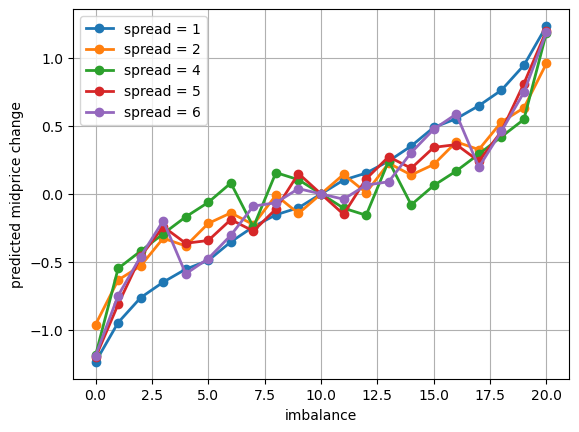

In [57]:
for s in micro_pricer.spread_set[:5]:
    plt.plot(micro_pricer.imb_set, micro_pricer.G[s], '-o', label=f'spread = {s}', linewidth=2)
plt.grid()
plt.legend()
plt.xlabel("imbalance")
plt.ylabel('predicted midprice change')
plt.show()

In [58]:
pred = micro_pricer.predict(imb, spread)

In [59]:
pred

array([ 1.2363866,  1.2363866,  1.2363866, ..., -1.2363866, -1.2363866,
       -1.2363866])

In [60]:
pred[:20]

array([1.2363866 , 1.2363866 , 1.2363866 , 1.2363866 , 1.2363866 ,
       1.2363866 , 1.2363866 , 1.2363866 , 1.2363866 , 0.24148173,
       0.24148173, 0.24148173, 0.24148173, 0.24148173, 0.24148173,
       0.24148173, 0.24148173, 0.24148173, 0.24148173, 0.35268035])

In [61]:
np.mean(dm)

0.0044372996581478075

In [62]:
np.mean(pred)

-0.022288698867731944

In [63]:
dm_test = np.diff(test.mid_price.values)
imb_test = test.imbalance.values
spread_test = test.spread.values

In [64]:
pred = micro_pricer.predict(imb_test, spread_test)

In [66]:
np.mean(pred)

-7.905959487434042e-05

In [68]:
np.mean(dm_test)

-0.0006653044227733678

In [69]:
pred[:20]

array([-1.2363866 , -1.2363866 , -1.2363866 , -1.2363866 , -1.2363866 ,
       -1.2363866 , -1.2363866 , -1.2363866 , -1.2363866 , -1.2363866 ,
       -0.99073245, -0.14132713, -0.64915381, -0.94696407, -0.76342897,
       -1.2363866 , -0.08485396, -1.0963716 ,  0.35268035, -0.32633088])

In [70]:
dm_test[:20]

array([ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
       -6.6 , -1.5 , -0.3 ,  0.1 ,  0.  ,  0.  , -0.75, -0.9 , -2.55,
       -0.1 ,  0.  ])

In [71]:
print(*zip(pred[:20], dm_test[:20]), sep='\n')

(-1.2363865967989507, 0.0)
(-1.2363865967989507, 0.0)
(-1.2363865967989507, 0.0)
(-1.2363865967989507, 0.0)
(-1.2363865967989507, 0.0)
(-1.2363865967989507, 0.0)
(-1.2363865967989507, 0.0)
(-1.2363865967989507, 0.0)
(-1.2363865967989507, 0.0)
(-1.2363865967989507, -6.600000000002183)
(-0.9907324502538462, -1.5)
(-0.14132713447365325, -0.2999999999992724)
(-0.6491538123060377, 0.09999999999854481)
(-0.946964074951494, 0.0)
(-0.7634289739159006, 0.0)
(-1.2363865967989507, -0.75)
(-0.08485396162605215, -0.8999999999978172)
(-1.0963715994214236, -2.5499999999992724)
(0.35268035447931, -0.09999999999854481)
(-0.3263308829214121, 0.0)


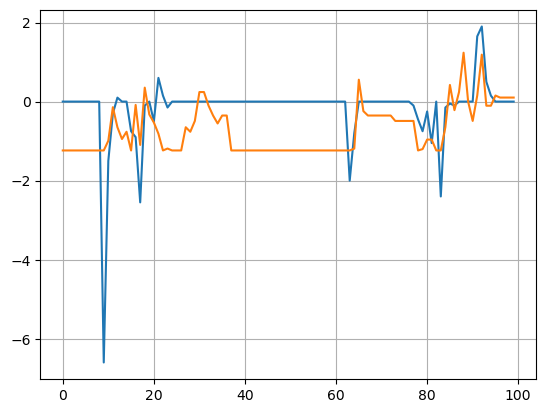

In [75]:
idx = slice(0, 100, 1)
plt.plot(dm_test[idx])
plt.plot(pred[idx])
plt.grid()
plt.show()